In [1]:
import math
import torch
import torch.nn as nn

if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
device = torch.device(dev)

def get_generators(k: int, l: int, m: int, D: int=50) -> list[torch.nn.Module]:
    return [build_generator(l, m, D) for _ in range(k)]


@torch.no_grad()
def get_regression_targets(n:int, k: int, l: int, generators: list[torch.nn.Module], sample_mode: str='random') -> tuple[torch.Tensor, torch.Tensor]:
    if sample_mode == 'random':
        z = torch.rand(n, k, l)
    elif sample_mode == 'diagonal':
        z = torch.repeat_interleave(torch.rand(n, l), k, dim=0)
        z = torch.reshape(z, (n, k, l))
    elif sample_mode == 'orthogonal':
        _z = torch.rand(n, l)
        mask = torch.stack([torch.arange(n), torch.randint(k, (n, 1)).squeeze(dim=1)], dim=1).long()
        z = torch.zeros(n, k, l)
        z[mask.chunk(chunks=2, dim=1)] = _z.unsqueeze(1)
    
    x = [torch.stack([generators[j](z[i][j]) for j in range(k)]) for i in range(n)]
    x = torch.stack(x)

    return z, x

def build_generator(l: int, m: int, D: int, slope: float=0.2) -> nn.Sequential:
    g = nn.Sequential(
        nn.Linear(l, D),
        nn.LeakyReLU(slope),
        nn.Linear(D, m),
        nn.LeakyReLU(slope)
    )
    g.apply(init_min_cond)
    return g


def init_min_cond(m: torch.nn.Module, n_samples: int=7500) -> torch.Tensor:
    if isinstance(m, nn.Linear):
        w = m.weight.data
        k = 1 / w.size(0)

        w = torch.nn.functional.normalize(w, p=2)
        cond = condition_number(w)

        for _ in range(n_samples):
            _w = 2 * math.sqrt(k) * torch.rand(w.size()) - math.sqrt(k)
            _w = nn.functional.normalize(_w, p=2)
            _cond = condition_number(_w)

            if _cond < cond:
                w = _w
                cond = _cond
        
        m.weight.data = w


def condition_number(t: torch.Tensor) -> float:
    return torch.norm(t, p=2) / torch.norm(torch.pinverse(t), p=2)


In [2]:
def build_MLP(d_in: int, d_out: int, D: int=120, slope: float=0.2, **kwargs) -> nn.Sequential:
    return nn.Sequential(
        nn.Linear(d_in, D),
        nn.LeakyReLU(slope),
        nn.Linear(D, d_out),
        nn.LeakyReLU(slope)
    )


def MLP(k: int, l: int, m: int, D: int=120, **kwargs):
    return build_MLP(k * m, k * l, D, **kwargs)


def MLPTanh(k: int, l: int, m: int, D: int=120, **kwargs):
    return nn.Sequential(
        nn.Linear(k * m, D),
        nn.Tanh(),
        nn.Linear(D, k * l),
        nn.Tanh()
    )


class CompositionalMLP(torch.nn.Module):
    def __init__(self, k: int, l: int, m: int, D: int=120, **kwargs):
        super(CompositionalMLP, self).__init__()
        self.k = k
        self.models = nn.ModuleList([build_MLP(k * m, l, round(D / k), **kwargs) for _ in range(k)])
    
    def forward(self, x):
        x = x.reshape(x.size(0), self.k, -1)
        out = []
        for i in range(len(self.models)):
            x_i = torch.zeros_like(x)
            x_i[:, i, :] = x[:, i, :]
            x_i = torch.flatten(x_i, start_dim = 1)
            out.append(self.models[i](x_i))
        return torch.cat(out, dim=1)


class Autoencoder(torch.nn.Module):
    def __init__(self, k: int, l: int, m: int, D: int=120, **kwargs):
        super(Autoencoder, self).__init__()
        self.f = build_MLP(k * m, k * l, D, **kwargs)
        self.g = build_MLP(k * l, k * m, D, **kwargs)
    
    def forward(self, x):
        z = self.f(x)
        out = self.g(z)
        return out, z

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import functorch
from torchmetrics import R2Score
from tqdm import tqdm


# could be more efficient with torch.utils.data.TensorDataset, but I couldn't be assed to look up the documentation
class Dataset(torch.utils.data.Dataset):
    def __init__(self, n: int, k: int, l: int, generators: list[torch.nn.Module], sample_mode: str='random'):
        super(Dataset, self).__init__()
        self.n = n
        self.z, self.x = get_regression_targets(n, k, l, generators, sample_mode)
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        return self.x[idx], self.z[idx]


def train(model: torch.nn.Module, trainloader: torch.utils.data.DataLoader, lr: float=0.001, epochs: int=10):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # for epoch in tqdm(range(epochs)):
    for epoch in range(epochs):
        cum_loss = 0

        for batch, data in enumerate(trainloader, 0):
            x, z = data

            optimizer.zero_grad()

            out = model(torch.flatten(x, start_dim=1))
            loss = criterion(out, torch.flatten(z, start_dim=1))
            cum_loss += loss
            loss.backward()
            optimizer.step()
        
        cum_loss /= (batch + 1)
    
    return cum_loss


# train for the same number of iterations (batches) independent of dataset size (i.e. without epochs)
def train_iter(model: torch.nn.Module, trainloader: torch.utils.data.DataLoader, lr: float=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    cum_loss = 0

    for batch, data in enumerate(trainloader, 0):
        x, z = data

        optimizer.zero_grad()

        out = model(torch.flatten(x.to(dev), start_dim=1))
        loss = criterion(out, torch.flatten(z.to(dev), start_dim=1))
        cum_loss += loss
        loss.backward()
        optimizer.step()
    
    cum_loss /= (batch + 1)
    return cum_loss.to(torch.device('cpu')).item()


# train for the same number of iterations (batches) independent of dataset size (i.e. without epochs)
def train_iter_reg(model: torch.nn.Module, trainloader: torch.utils.data.DataLoader, regularization, lamda: float=0.5, lr: float=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    cum_loss = 0

    for batch, data in enumerate(trainloader, 0):
        x, z = data

        optimizer.zero_grad()

        x.requires_grad = True
        x = x.flatten(1).to(dev)
        z = z.flatten(1).to(dev)

        z_hat = model(x)
        loss = criterion(z_hat, z) + lamda * regularization(model, x)
        cum_loss += loss
        loss.backward()
        optimizer.step()
    
    cum_loss /= (batch + 1)
    return cum_loss.to(torch.device('cpu')).item()


# train for the same number of iterations (batches) independent of dataset size (i.e. without epochs)
def train_iter_reg_ae(enc: torch.nn.Module, dec: torch.nn.Module, trainloader: torch.utils.data.DataLoader, regularization, lamda: float=0.5, lr: float=0.001):
    criterion = nn.MSELoss()
    reconstruction = nn.L1Loss()
    optimizer = optim.SGD({'encoder': enc.parameters(), 'decoder': dec.parameters()}, lr=lr, momentum=0.9)

    cum_loss = 0

    for batch, data in enumerate(trainloader, 0):
        x, z = data

        optimizer.zero_grad()

        x.requires_grad = True
        x = x.flatten(1).to(dev)
        z = z.flatten(1).to(dev)

        z_hat = enc(x)
        x_hat = dec(z_hat)
        loss = criterion(z_hat, z) + reconstruction (x, x_hat) + lamda * regularization(dec, x)
        cum_loss += loss
        loss.backward()
        optimizer.step()
    
    cum_loss /= (batch + 1)
    return cum_loss.to(torch.device('cpu')).item()


def comp_contrast2(func: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    """Calculate the compositional contrast for a function `func` with respect to `inputs`.

    The output is calculated as the mean over the batch dimension.
    `inputs` needs to be flattened except for the batch dimension and `requires_grad` needs to be set to `True`.
    """
    assert inputs.requires_grad == True, 'To calculate the derivative by `inputs` `requires_grad` needs to be set to `True`.'

    # compute the jacobian with respect to the inputs
    jac = functorch.vmap(functorch.jacrev(func))(inputs).transpose(1, 2)

    # compute the compositional contrast as the sum of all pairs of partial derivatives for all outputs
    # average over the batch dimension
    cc = torch.abs(jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1)) * torch.abs(jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1).transpose(2, 3))

    block_diagonal = torch.block_diag(*torch.ones(4, 2, 2, dtype=bool)).to(dev)

    cc = torch.where(~block_diagonal, cc, 0).triu(1).sum((1, 2, 3)).mean()

    return cc


def sparse_hess(func: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    # FIXME parameterize which norm to use
    hess = functorch.vmap(functorch.hessian(func))(inputs)

    return torch.mean(hess.norm(dim=(1, 2, 3), p=0))


def sparse_hess2(func: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    # FIXME change sum() to norm
    mask = torch.ones(8, 40, 40, dtype=torch.uint8).to(dev)
    for i in range(4):
        mask[i*2:(i+1)*2, i*10:(i+1)*10, i*10:(i+1)*10] = 0
    
    hess = functorch.vmap(functorch.hessian(func))(inputs)

    return torch.masked_select(hess, mask).sum()


@torch.no_grad()
def test(model: torch.nn.Module, testloader: torch.utils.data.DataLoader):
    cum_score = 0

    for batch, data in enumerate(testloader, 0):
        x, z = data
        out = model(torch.flatten(x.to(dev), start_dim=1))
        r2score = R2Score(out.size(1)).to(dev)
        score = r2score(out, torch.flatten(z.to(dev), start_dim=1))
        cum_score += score
    
    cum_score /= (batch + 1)
    return cum_score.to(torch.device('cpu')).item()

In [4]:
import copy

k = 4
l = 2
m = 10

torch.manual_seed(0)

print('Build generators...')
g = get_generators(k, l, m)

print('Build test data...')
te_ds = Dataset(1000, k, l, g, 'random')
te_ldr = torch.utils.data.DataLoader(te_ds, batch_size=1000, shuffle=True)

Build generators...
Build test data...


In [5]:
bs = 4
nb = int(2**13 / bs)

res = []
log_n = 12
n = 2**log_n
print(f'n={n:4d}')

print('Build train data...')
tr_ds_rand = Dataset(n, k, l, g, 'random')
tr_ds_diag = Dataset(n, k, l, g, 'diagonal')
tr_ds_orth = Dataset(n, k, l, g, 'orthogonal')

tr_ldr_rand = torch.utils.data.DataLoader(tr_ds_rand, batch_sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(tr_ds_rand, num_samples=nb), bs, False))
tr_ldr_diag = torch.utils.data.DataLoader(tr_ds_diag, batch_sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(tr_ds_diag, num_samples=nb), bs, False))
tr_ldr_orth = torch.utils.data.DataLoader(tr_ds_orth, batch_sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(tr_ds_orth, num_samples=nb), bs, False))

print('Build models...')
mlp_rand = MLPTanh(k, l, m).to(dev)
mlp_diag = copy.deepcopy(mlp_rand)
mlp_orth = copy.deepcopy(mlp_rand)

print('Train models...')
for i in tqdm(range(500)):
    res.append({'metric': 'train loss', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'tanh & sparse hess', 'sampling': 'random', 'val': train_iter_reg(mlp_rand, tr_ldr_rand, sparse_hess)})
    res.append({'metric': 'test R²', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'tanh & sparse hess', 'sampling': 'random', 'val': test(mlp_rand, te_ldr)})
    res.append({'metric': 'train loss', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'tanh & sparse hess', 'sampling': 'diagonal', 'val': train_iter_reg(mlp_diag, tr_ldr_diag, sparse_hess)})
    res.append({'metric': 'test R²', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'tanh & sparse hess', 'sampling': 'diagonal', 'val': test(mlp_diag, te_ldr)})
    res.append({'metric': 'train loss', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'tanh & sparse hess', 'sampling': 'orthogonal', 'val': train_iter_reg(mlp_orth, tr_ldr_orth, sparse_hess)})
    res.append({'metric': 'test R²', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'tanh & sparse hess', 'sampling': 'orthogonal', 'val': test(mlp_orth, te_ldr)})

import pandas as pd
res_df = pd.DataFrame.from_dict(res)

import pickle as pk
with open(r'res_i500_lr0001_all_hess.pkl', 'wb') as f:
    pk.dump(res_df, f)

torch.save(mlp_rand.state_dict(), 'mod_i500_lr0001_rand_hess.pth')
torch.save(mlp_diag.state_dict(), 'mod_i500_lr0001_diag_hess.pth')
torch.save(mlp_orth.state_dict(), 'mod_i500_lr0001_orth_hess.pth')

n=4096
Build train data...
Build models...
Train models...


100%|██████████| 500/500 [1:08:16<00:00,  8.19s/it]


ModuleNotFoundError: No module named 'pandas'

In [9]:
bs = 4
nb = int(2**13 / bs)

res = []
log_n = 12
n = 2**log_n
print(f'n={n:4d}')

print('Build train data...')
tr_ds_rand = Dataset(n, k, l, g, 'random')
tr_ds_diag = Dataset(n, k, l, g, 'diagonal')
tr_ds_orth = Dataset(n, k, l, g, 'orthogonal')

tr_ldr_rand = torch.utils.data.DataLoader(tr_ds_rand, batch_sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(tr_ds_rand, num_samples=nb), bs, False))
tr_ldr_diag = torch.utils.data.DataLoader(tr_ds_diag, batch_sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(tr_ds_diag, num_samples=nb), bs, False))
tr_ldr_orth = torch.utils.data.DataLoader(tr_ds_orth, batch_sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(tr_ds_orth, num_samples=nb), bs, False))

print('Build models...')
mlp_rand = MLPTanh(k, l, m).to(dev)
mlp_diag = copy.deepcopy(mlp_rand)
mlp_orth = copy.deepcopy(mlp_rand)

print('Train models...')
for i in tqdm(range(500)):
    res.append({'metric': 'train loss', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'tanh & sparse hess', 'sampling': 'random', 'val': train_iter_reg(mlp_rand, tr_ldr_rand, sparse_hess)})
    res.append({'metric': 'test R²', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'tanh & sparse hess', 'sampling': 'random', 'val': test(mlp_rand, te_ldr)})
    res.append({'metric': 'train loss', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'tanh & sparse hess', 'sampling': 'diagonal', 'val': train_iter_reg(mlp_diag, tr_ldr_diag, sparse_hess)})
    res.append({'metric': 'test R²', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'tanh & sparse hess', 'sampling': 'diagonal', 'val': test(mlp_diag, te_ldr)})
    res.append({'metric': 'train loss', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'tanh & sparse hess', 'sampling': 'orthogonal', 'val': train_iter_reg(mlp_orth, tr_ldr_orth, sparse_hess)})
    res.append({'metric': 'test R²', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'tanh & sparse hess', 'sampling': 'orthogonal', 'val': test(mlp_orth, te_ldr)})

import pandas as pd
res_df = pd.DataFrame.from_dict(res)

import pickle as pk
with open(r'res_i500_lr0001_all_hess2.pkl', 'wb') as f:
    pk.dump(res_df, f)

torch.save(mlp_rand.state_dict(), 'mod_i500_lr0001_rand_hess2.pth')
torch.save(mlp_diag.state_dict(), 'mod_i500_lr0001_diag_hess2.pth')
torch.save(mlp_orth.state_dict(), 'mod_i500_lr0001_orth_hess2.pth')

n=4096
Build train data...
Build models...
Train models...


  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_154982/2069984988.py:198: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352616446/work/aten/src/ATen/native/IndexingUtils.h:28.)
  return torch.masked_select(hess, mask).sum()
/home/bethge/twiedemer43/.conda/envs/iood/lib/python3.9/site-packages/torch/autograd/__init__.py:173: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352616446/work/aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 500/500 [1:13:30<00:00,  8.82s/it]


In [110]:
with open(r'res/i500_lr0001_all.pkl', 'rb') as f:
    normal = pk.load(f)
    normal = normal.loc[normal['n samples'] == 4096]
with open(r'res/i500_lr0001_all_hess.pkl', 'rb') as f:
    hess = pk.load(f)
with open(r'res/i500_lr0001_all_jac2.pkl', 'rb') as f:
    jac = pk.load(f)
    jac['model'] = jac['model'].replace({'normal': 'comp contrast'})

res_df = pd.merge(jac, hess, 'outer')
res_df = pd.merge(res_df, normal, 'outer')

[Text(27.67233506944445, 0.5, 'R² score'),
 Text(443.38261766975313, 0.5, 'R² score'),
 Text(827.7179002700617, 0.5, 'R² score')]

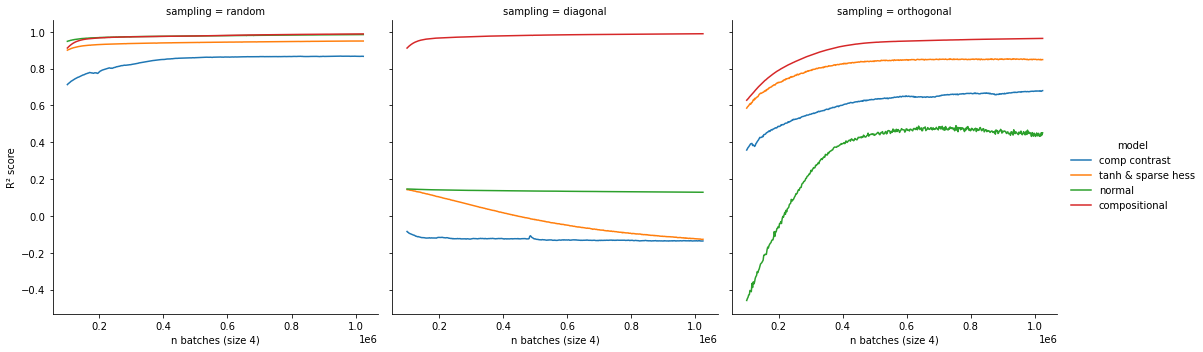

In [133]:
import seaborn as sb
fg = sb.relplot(data=res_df.loc[(res_df['metric'] == 'test R²') & (res_df['n batches'] > 100000)], x='n batches', y='val', hue='model', col='sampling', kind='line')
[_fg.set_xlabel('n batches (size 4)') for _fg in fg.axes.ravel()]
[_fg.set_ylabel('R² score') for _fg in fg.axes.ravel()]

In [107]:
mlp = MLPTanh(k, l, m).to(dev)
mlp.load_state_dict(torch.load('mod_i500_lr0001_rand_hess.pth'))

<All keys matched successfully>

<function matplotlib.pyplot.show(close=None, block=None)>

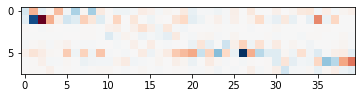

In [108]:
jac = functorch.jacrev(mlp)(torch.rand((4, 10)).flatten().to(dev))

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

plt.imshow(jac.detach().cpu().numpy(), cmap='RdBu', norm=colors.TwoSlopeNorm(0))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

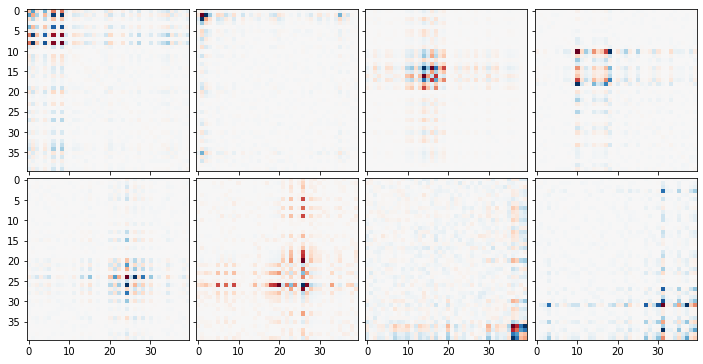

In [109]:
hess = functorch.hessian(mlp)(torch.rand((4, 10)).flatten().to(dev))

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12., 24.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, list(hess.detach().cpu().numpy())):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='RdBu', norm=colors.TwoSlopeNorm(0))

plt.show